# Importing Lib



In [3]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [5]:
data = pd.read_csv('/kaggle/input/imu-db/ALL_FAIL_LOG_IMU_0_Add_Random (2).csv')


# Preprocessing and Exploring data



In [6]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (21597, 17)

Columns:
 Index(['LineNo', 'abTimeUS', 'abI', 'abGyrX', 'abGyrY', 'abGyrZ', 'abAccX',
       'abAccY', 'abAccZ', 'abEG', 'abEA', 'abT', 'abGH', 'abAH', 'abGHz',
       'abAHz', 'labels'],
      dtype='object')

Sample Data:
    LineNo   abTimeUS  abI    abGyrX    abGyrY     abGyrZ    abAccX    abAccY  \
0   14707   47623443    0  0.000652  0.000699   0.000664 -0.001625 -0.000529   
1  294758  359383689    0  3.323413 -5.883018  -6.913023  0.528758 -1.198488   
2  288150  352023301    0  4.783490 -6.518798 -28.446280 -0.080333 -0.054142   
3  265078  326383561    0  1.152616 -2.402375  -0.117582 -0.328573  0.036870   
4  105572  148903748    0  1.405822 -2.136524   0.033208 -5.092781 -0.064265   

      abAccZ  abEG  abEA       abT  abGH  abAH  abGHz  abAHz  labels  
0  -9.817689     0     0  27.83643     1     1   1000   1000       0  
1  -6.869982     0     0  38.92860     1     1    999    999       3  
2  -8.466424     0     0  38.77781     1     1    999

In [7]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo        int64
abTimeUS      int64
abI           int64
abGyrX      float64
abGyrY      float64
abGyrZ      float64
abAccX      float64
abAccY      float64
abAccZ      float64
abEG          int64
abEA          int64
abT         float64
abGH          int64
abAH          int64
abGHz         int64
abAHz         int64
labels        int64
dtype: object


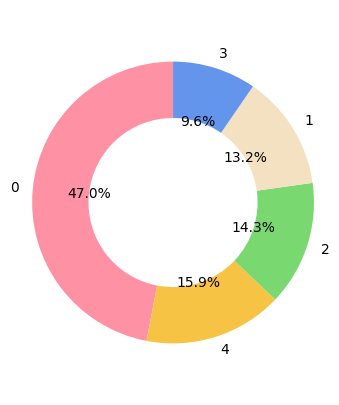

In [8]:

if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    # Define specific colors for 5 labels
    colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

    # Plot the donut chart
    plt.figure(figsize=(4, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': 0.4})
    plt.axis('equal')
    plt.show()



In [9]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [10]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [11]:
X.shape

(21597, 16)

In [12]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [14]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [15]:
X_reshaped.shape

(21597, 1, 16)

In [16]:
for label in data['labels'].unique():
    print(f"\nValues for label: {label}")
    print(data[data['labels'] == label].head())


Values for label: 0
   LineNo   abTimeUS  abI    abGyrX    abGyrY    abGyrZ    abAccX    abAccY  \
0   14707   47623443    0  0.000652  0.000699  0.000664 -0.001625 -0.000529   
3  265078  326383561    0  1.152616 -2.402375 -0.117582 -0.328573  0.036870   
5  337042  406384048    0  2.900586 -0.807860  0.105744 -4.811216  0.004499   
7    8795   24183656    0  0.000277  0.000300  0.000334 -0.001067 -0.001277   
8  147682  195903274    0 -2.509628 -0.916222  0.052631 -4.793435 -0.102203   

      abAccZ  abEG  abEA       abT  abGH  abAH  abGHz  abAHz  labels  
0  -9.817689     0     0  27.83643     1     1   1000   1000       0  
3 -10.058320     0     0  38.22263     1     1    999    999       0  
5  -8.781097     0     0  39.80902     1     1   1000   1000       0  
7  -9.816331     0     0  26.44160     1     1    999    999       0  
8  -8.323733     0     0  34.52991     1     1   1000   1000       0  

Values for label: 3
    LineNo   abTimeUS  abI    abGyrX    abGyrY     abGyrZ

# Model

In [17]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [18]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [19]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    # inputs = Input(shape=input_shape)
# def build_tcn_attention_model(X_reshaped, num_classes):
    inputs = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
     # Replacing input_shape with X_reshaped.shape
    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model


In [20]:
# input_shape
X_reshaped.shape[2]

16

In [21]:
X_reshaped.shape[1]

1

In [22]:
X_reshaped.shape[0]

21597

In [23]:
X_reshaped.shape

(21597, 1, 16)

In [24]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [25]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuraciesKF = []
label_accuraciesKF = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_foldKF, X_val_foldKF = X_reshaped[train_index], X_reshaped[val_index]
    y_train_foldKF, y_val_foldKF = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    # modelKF = build_tcn_attention_model(input_shape, num_classes)
    modelKF = build_tcn_attention_model(X_reshaped, num_classes)
    modelKF.fit(X_train_foldKF, y_train_foldKF, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_foldKF, y_val_foldKF))

    # Evaluate the model
    lossKF, accuracyKF = modelKF.evaluate(X_val_foldKF, y_val_foldKF, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracyKF:.4f}")
    accuraciesKF.append(accuracyKF)

    # Predictions
    y_predKF = modelKF.predict(X_val_foldKF)
    y_pred_classesKF = np.argmax(y_predKF, axis=1)
    y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

    # Accuracy per label
    label_accKF = []
    for label in range(num_classes):
        label_indicesKF = (y_true_classesKF == label)
        label_accKF.append(accuracy_score(y_true_classesKF[label_indicesKF], y_pred_classesKF[label_indicesKF]))
    label_accuraciesKF.append(label_accKF)

    fold_no += 1




Training fold 1...


I0000 00:00:1744633400.222611      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744633400.223381      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1744633405.703423      95 service.cc:148] XLA service 0x460d7020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744633405.704177      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744633405.704195      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744633406.161802      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744633408.812339      95 device_compiler.h:188] Compiled cluster u

Validation Accuracy for fold 1: 0.9764
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Training fold 2...
Validation Accuracy for fold 2: 0.9639
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Training fold 3...
Validation Accuracy for fold 3: 0.9741
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Training fold 4...
Validation Accuracy for fold 4: 0.9486
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Training fold 5...
Validation Accuracy for fold 5: 0.9474
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [26]:
modelKF.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 1, 64)               │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,705 (385.57 KB)

 Trainable params: 32,773 (128.02 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 65,548 (256.05 KB)

In [27]:
# Calculate average accuracy
average_accuracyKF = np.mean(accuraciesKF)
print(f"\nAverage Accuracy across all folds: {average_accuracyKF:.4f}")


Average Accuracy across all folds: 0.9621


In [28]:
# Average accuracy per label
label_accuraciesKF = np.mean(label_accuraciesKF, axis=0)
for idx, acc in enumerate(label_accuraciesKF):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9570
Label 1 Accuracy: 0.9633
Label 2 Accuracy: 0.9702
Label 3 Accuracy: 0.9606
Label 4 Accuracy: 0.9710


In [29]:
# Evaluate the last fold predictions
y_predKF = modelKF.predict(X_val_foldKF)
y_pred_classesKF = np.argmax(y_predKF, axis=1)
y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [30]:
import pandas as pd
import numpy as np

feature_names = ["DesRoll", "Roll", "DesPitch", "Pitch", "DesYaw", "Yaw", "ErrRP", "ErrYaw",
                 "MagX", "MagY", "MagZ", "abGyrX", "abGyrY", "abGyrZ", "abAccX", "abAccY"]


# Step 1: Get Model Predictions
y_pred_probs = modelKF.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Filter only misclassified samples
mismatch_indices = y_true_labels != y_pred_labels  # Boolean mask for incorrect predictions

# Step 3: Print only misclassified rows
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]))  # Flatten features
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

print(df_mismatches)  # Print all misclassified cases




675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
             0         1    2         3         4         5         6  \
0     1.670653  1.588646  0.0  1.046993 -0.797983  0.088337  0.485091   
1    -0.064013 -0.154422  0.0  0.021514  1.437125 -0.103075  0.930460   
2    -0.074009 -0.164543  0.0  1.855041 -0.001532  0.112145  0.930460   
3    -1.204392 -1.304400  0.0  1.432977  0.004636 -0.055345  0.237327   
4    -1.153252 -1.253161  0.0 -0.711654 -1.024918  0.085628 -0.063802   
...        ...       ...  ...       ...       ...       ...       ...   
1146  0.718069  0.858102  0.0 -1.540890  0.249904  0.092924 -0.915454   
1147 -1.109392 -0.981622  0.0 -0.522028  1.276152  0.086866  0.111170   
1148  0.154184  0.291394  0.0 -0.700948  1.099680  0.154768  0.930460   
1149  0.341393  0.479479  0.0  1.224450 -0.296946  0.087453  0.473579   
1150 -1.147643 -1.019972  0.0 -1.104376  0.730717  0.091714  0.125374   

             7         8    9   10        11   12   13        14        15  \
0   

In [31]:
import pandas as pd
import numpy as np

feature_names = ["LineNo", "abTimeUS", "abI", "abGyrX", "abGyrY", "abGyrZ", "abAccX",
       "abAccY", "abAccZ", "abEG", "abEA", "abT", "abGH", "abAH", "abGHz",
       "abAHz"]

# Step 1: Get Model Predictions
y_pred_probs = modelKF.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Identify misclassified samples and their indices
mismatch_indices = np.where(y_true_labels != y_pred_labels)[0]  # Get actual indices

# Step 3: Create DataFrame of misclassified samples with indices
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_mismatches['Index'] = mismatch_indices  # Add original index
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

# Print misclassified samples with their original indices
print(df_mismatches[['Index', 'Actual_Label', 'Predicted_Label'] + feature_names])


675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
      Index  Actual_Label  Predicted_Label    LineNo  abTimeUS  abI    abGyrX  \
0        16             4                0  1.670653  1.588646  0.0  1.046993   
1        29             2                0 -0.064013 -0.154422  0.0  0.021514   
2        37             2                0 -0.074009 -0.164543  0.0  1.855041   
3        84             0                1 -1.204392 -1.304400  0.0  1.432977   
4       113             0                1 -1.153252 -1.253161  0.0 -0.711654   
...     ...           ...              ...       ...       ...  ...       ...   
1146  21565             4                0  0.718069  0.858102  0.0 -1.540890   
1147  21566             0                1 -1.109392 -0.981622  0.0 -0.522028   
1148  21577             2                0  0.154184  0.291394  0.0 -0.700948   
1149  21585             3                0  0.341393  0.479479  0.0  1.224450   
1150  21588             0                1 -1.147643 -1.019972  0.0 

In [32]:
# Step 1: Identify correctly classified indices
correct_indices = np.where(y_true_labels == y_pred_labels)[0]

# Step 2: Create DataFrame of correctly classified samples
df_correct = pd.DataFrame(X_reshaped[correct_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_correct['Index'] = correct_indices  # Add original index
df_correct['Actual_Label'] = y_true_labels[correct_indices]
df_correct['Predicted_Label'] = y_pred_labels[correct_indices]

# Step 3: Save to CSV
df_correct.to_csv("correctly_classified.csv", index=False)

# Print first few rows
print(df_correct.head())


     LineNo  abTimeUS  abI    abGyrX    abGyrY     abGyrZ    abAccX    abAccY  \
0 -1.552804 -1.653873  0.0 -0.027458  0.042691   0.066950  0.477452 -0.064619   
1  0.823489  0.737517  0.0  1.861191 -3.176801  -3.021359  0.717329 -1.375929   
2  0.767419  0.681058  0.0  2.691095 -3.524692 -12.640154  0.441855 -0.123306   
3  0.571648  0.484386  0.0  0.627316 -1.272240   0.014130  0.329582 -0.023682   
4 -0.781795 -0.876992  0.0  0.771237 -1.126770   0.081487 -1.825136 -0.134387   

     abAccZ  abEG  abEA       abT  abGH  abAH     abGHz     abAHz  Index  \
0 -0.509609   0.0   0.0 -2.037772   0.0   0.0  0.848641  0.848641      0   
1  0.175389   0.0   0.0  0.791822   0.0   0.0 -1.178355 -1.178355      1   
2 -0.195597   0.0   0.0  0.753356   0.0   0.0 -1.178355 -1.178355      2   
3 -0.565528   0.0   0.0  0.611730   0.0   0.0 -1.178355 -1.178355      3   
4 -0.182883   0.0   0.0 -0.783275   0.0   0.0  0.848641  0.848641      4   

   Actual_Label  Predicted_Label  
0             0      

In [33]:
df_mismatches.to_csv("misclassified_samples.csv", index=False)
print("CSV file 'misclassified_samples.csv' saved successfully!")


CSV file 'misclassified_samples.csv' saved successfully!


In [34]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classesKF, y_pred_classesKF,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9532    0.9332    0.9431      2006
           1     0.8153    0.9907    0.8945       539
           2     0.9818    0.9475    0.9643       628
           3     0.9922    0.9574    0.9745       399
           4     1.0000    0.9491    0.9739       747

    accuracy                         0.9474      4319
   macro avg     0.9485    0.9556    0.9501      4319
weighted avg     0.9518    0.9474    0.9483      4319



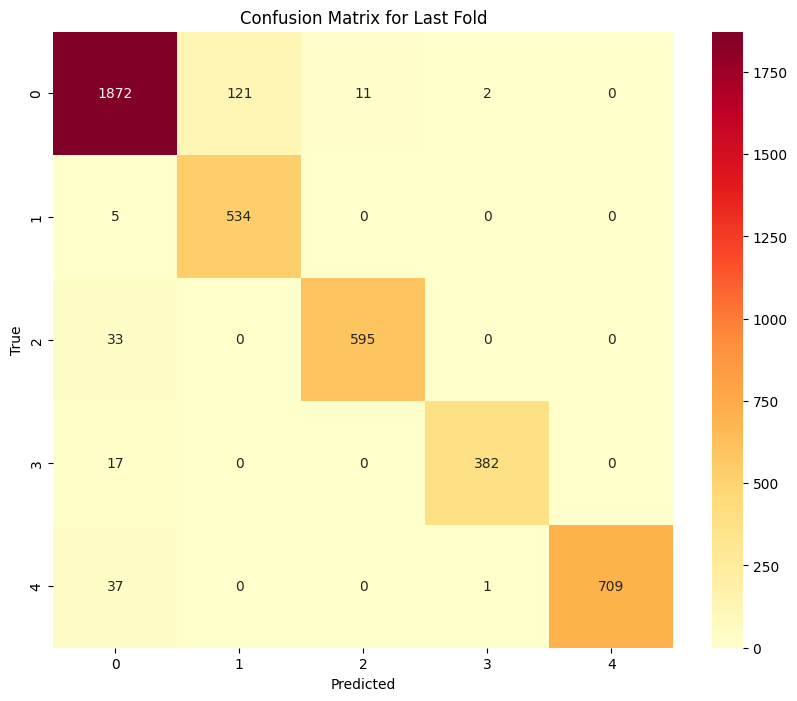

In [35]:
# Confusion Matrix
conf_matrixKF = tf.math.confusion_matrix(y_true_classesKF, y_pred_classesKF)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrixKF, annot=True, fmt='d', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for Last Fold')
plt.show()


Label Distribution:
 labels
0    10147
4     3440
2     3092
1     2846
3     2072
Name: count, dtype: int64


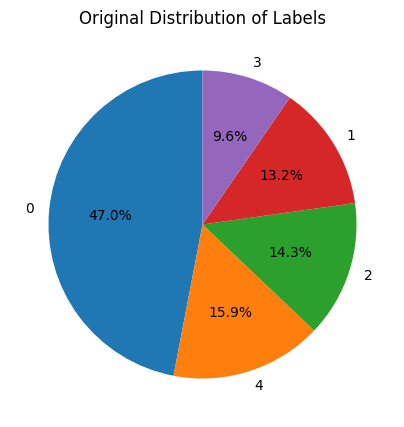

In [36]:
if 'labels' in data.columns:
    label_countsKF = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_countsKF)
    plt.figure(figsize=(5, 5))
    plt.pie(label_countsKF, labels=label_countsKF.index, autopct='%1.1f%%', startangle=90)
    plt.title('Original Distribution of Labels')
    plt.show()

0    1964
4     709
1     655
2     606
3     385
Name: count, dtype: int64


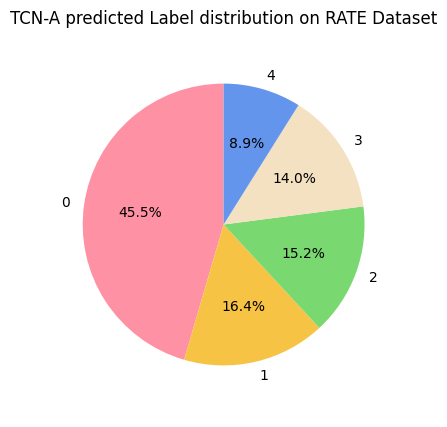

In [37]:

# Get the label distribution after training
# Get the predicted labels after training
class_counts = pd.Series(y_pred_classesKF).value_counts()
print(class_counts)
# Plot pie chart of predicted labels
plt.figure(figsize=(4, 5))
colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]
plt.pie(pd.Series(y_pred_classesKF).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90,colors=colors)
plt.axis('equal')
plt.title('TCN-A predicted Label distribution on RATE Dataset')
plt.show()

# SHAP (According to Ma'am)

In [ ]:
import shap
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Flatten data for clustering (keeping shape (4319, 16))
X_flat = X_reshaped.reshape(X_reshaped.shape[0], -1)  # (4319, 16)

# Step 2: Apply KMeans clustering to select representative background data
num_clusters = 20  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_flat)

# Step 3: Select cluster centers as background data
background_data_kmeans = kmeans.cluster_centers_

# Step 4: Define SHAP KernelExplainer (Model-Agnostic)
def model_predict(X):
    X_input = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape back to (N, 1, 16) for TCN
    return modelKF.predict(X_input)

# Step 5: Create KernelExplainer
explainer_kernel = shap.KernelExplainer(model_predict, background_data_kmeans)

# Step 6: Compute SHAP values on a test subset
X_test_sample = X_flat[:4000]  # Selecting a subset for SHAP analysis
shap_values_kernel = explainer_kernel.shap_values(X_test_sample,silent=False)

# Step 7: Visualize SHAP summary plot
# shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  0%|          | 0/4000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [45]:
X_flat.shape

(21597, 16)

In [46]:
shap_values_kernel

[array([[ 0.13314781,  0.31865239,  0.        , ...,  0.        ,
         -0.00034934, -0.00612363],
        [-0.04861838, -0.10295856,  0.        , ...,  0.        ,
          0.0076775 , -0.00622841],
        [-0.04538027,  0.00560046,  0.        , ...,  0.        ,
          0.01082522, -0.00893659],
        ...,
        [-0.06794666,  0.02770449,  0.        , ...,  0.        ,
          0.0410331 , -0.04876959],
        [ 0.11800827, -0.2600846 ,  0.        , ...,  0.        ,
          0.02535482, -0.04192594],
        [-0.30809102, -0.00520216,  0.        , ...,  0.        ,
          0.0013574 , -0.07315241]]),
 array([[-0.00811182,  0.04120996,  0.        , ...,  0.        ,
         -0.0024967 , -0.00069789],
        [-0.05023564, -0.05022008,  0.        , ...,  0.        ,
          0.0017083 ,  0.00573792],
        [-0.03525599, -0.03524629,  0.        , ...,  0.        ,
          0.0032419 ,  0.00345783],
        ...,
        [-0.04453557, -0.05778878,  0.        , ...,  

In [47]:
len(shap_values_kernel)

5

In [48]:
shap_values_kernel[0].shape

(4000, 16)

In [49]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 0  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [0.13314781005802054, 0.3186523934818011, 0.0, -0.02132778741911473, -0.02002862182503355, 0.009090093389159459, 0.09648892483305141, 0.03518754551466914, 0.00880981371245243, 0.0, 0.0, 0.07053984708913388, 0.0, 0.0, -0.0003493442957850584, -0.006123627433700318]
Feature 1: [-0.0486183794238786, -0.10295856353493724, 0.0, -0.020834617173879733, 0.014234326855967136, -0.09301748891522765, -0.050161357868584076, -0.10144756065985414, -0.032959671132353104, 0.0, 0.0, 0.05857097878607666, 0.0, 0.0, 0.007677497516951682, -0.00622840503537353]
Feature 2: [-0.04538027039747143, 0.005600462922129211, 0.0, -0.036108741661755664, 0.012126087507990026, -0.38645815781254717, -0.01564633744554422, 0.005645681231298873, 0.016290597725862416, 0.0, 0.0, 0.06629634950484806, 0.0, 0.0, 0.010825219419323103, -0.008936585369258399]
Feature 3: [0.02625990950049637, 0.11694593635788088, 0.0, 0.01876389108378613, 0.06335167116068456, 0.04167061021651268, 0.064

In [50]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 4  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the 199th data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the 199th data point:
Feature 0: [0.018106060403972172, -0.061685869529803726, 0.0, -0.0003244094919214975, 0.0001090310562745496, 0.0001907251705979889, -0.0020089052060216087, -0.006919043693210305, 0.008741985921640326, 0.0, 0.0, -0.019271782024015284, 0.0, 0.0, 0.0021817451490020374, 0.009054512721358661]
Feature 1: [0.029034923352611246, -0.03323999126447368, 0.0, 0.01083711388513391, -0.01034646522384928, -0.0478235674349112, 0.009360747453645592, 0.010277801568959993, -0.012337403479217838, 0.0, 0.0, -0.01095206087363303, 0.0, 0.0, 0.00012500007725386295, 0.0032379565130066443]
Feature 2: [0.04240030007824667, -0.03205757553429283, 0.0, 0.009211360776894726, -0.008362740351940684, -0.045490293765165696, -0.0004472780299447732, -0.005665376657539159, -0.0013320736544349219, 0.0, 0.0, -0.014108329011791963, 0.0, 0.0, 0.003670277371945532, 0.00035577855049059165]
Feature 3: [0.06135021896749377, -0.08187621336932935, 0.0, 0.004302203769603442, -0.0007355775731207753

In [51]:

len(shap_values_kernel)


5

In [52]:
shap_values_kernel[4].shape

(4000, 16)

In [87]:


import numpy as np
import pandas as pd

# Assuming feature_names is a list of 16 strings corresponding to your features
# Example: feature_names = ['feature_1', 'feature_2', ..., 'feature_16']
# You need to define feature_names based on your actual data
if 'feature_names' not in locals():
    feature_names = [f'feature_{i+1}' for i in range(16)] # Placeholder if you don't have them

# The error "ValueError: Shape of passed values is (4319, 16), indices imply (16, 5)"
# arises because you are trying to create a Pandas DataFrame where the shape of
# the data (4319 rows, 16 columns) does not match the shape implied by the
# index (16 rows) and columns (5 columns).

# It's highly likely that 'shap_importance_per_class' was incorrectly computed
# for the new shape of 'shap_values_kernel'.

# Based on the original code's intent, 'shap_importance_per_class' should have
# the shape (number_of_features, number_of_classes), which is (16, 5) in your case.

# The most probable scenario is that 'shap_values_kernel' with shape (4319, 16)
# contains the SHAP values for each of the 4319 data points across the 16 features,
# and you need to aggregate these to get the mean absolute importance per feature
# for each class.

# To resolve the error and align with the original goal, you need to:
# 1. Ensure you have SHAP values that are somehow associated with each of the 5 classes.
# 2. Calculate the mean absolute SHAP value per feature for each of these classes.

# Without knowing how your SHAP values are structured with respect to the classes,
# I will provide a general approach assuming you have access to class-specific
# SHAP values.

# Let's assume you have a way to get SHAP values for each class.
# This might involve iterating through the classes and calculating the mean absolute
# SHAP values per feature for the data points belonging to that class.

# Placeholder for how you would compute shap_importance_per_class
# This depends entirely on how your SHAP values and class labels are organized.

# Example scenario: You have the predicted class for each of the 4319 data points.
# You can then filter the shap_values_kernel based on these predicted classes.

# Assuming you have 'predicted_classes' as a NumPy array of shape (4319,)
# and 'class_names' as a list: ['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly']

if 'class_names' not in locals():
    class_names = ['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly']

if 'predicted_classes' in locals():
    shap_importance_per_class_list = []
    for class_name in class_names:
        # Get indices of data points predicted as the current class
        class_indices = np.where(predicted_classes == class_name)[0]
        if len(class_indices) > 0:
            # Extract SHAP values for these data points
            shap_values_for_class = shap_values_kernel[class_indices]
            # Calculate mean absolute SHAP value per feature for this class
            mean_abs_shap = np.mean(np.abs(shap_values_for_class), axis=0)
            shap_importance_per_class_list.append(mean_abs_shap)
        else:
            # Handle cases where a class might have no predictions
            shap_importance_per_class_list.append(np.zeros(16)) # Or some other appropriate handling

    shap_importance_per_class = np.array(shap_importance_per_class_list).T # Shape (16, 5)

else:
    # If you don't have predicted classes directly, you need to adapt this
    # based on how your SHAP values relate to the classes.
    print("Warning: 'predicted_classes' not found. Assuming a direct mapping is needed.")
    # This is a placeholder - you need to implement the correct way to get
    # mean absolute SHAP values per feature for each class from your data.
    shap_importance_per_class = np.random.rand(16, 5) # Placeholder with correct shape

# Now create the DataFrame with the correct shape
shap_df = pd.DataFrame(shap_importance_per_class, columns=class_names, index=feature_names)

# Display top contributing features for each anomaly type
for anomaly_class in shap_df.columns[1:]: # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df[anomaly_class].sort_values(ascending=False))


Top Contributing Features for GPS Anomaly:
abGyrX      0.993814
abAccX      0.779060
abAH        0.667817
abTimeUS    0.656565
abAccY      0.601148
LineNo      0.594821
abGyrY      0.493908
abT         0.478149
abEA        0.403772
abAHz       0.365268
abAccZ      0.331151
abGyrZ      0.303524
abGHz       0.268871
abI         0.230884
abEG        0.177536
abGH        0.083744
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
LineNo      0.994475
abT         0.698875
abEG        0.695318
abAHz       0.622944
abGyrY      0.565728
abGHz       0.515659
abGyrX      0.482602
abTimeUS    0.473894
abEA        0.415156
abI         0.410386
abAccZ      0.380165
abAccY      0.299750
abAH        0.236885
abAccX      0.149300
abGH        0.124801
abGyrZ      0.065085
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
abEA        0.978424
abAH        0.809681
abAccZ      0.796210
abI         0.607465
abGHz       0.590025


In [88]:
shap_df.columns

Index(['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly',
       'RC Anomaly'],
      dtype='object')

In [56]:
top_features = shap_df.iloc[:, 1:].idxmax()
print("\nMost Contributing Feature for Each Anomaly Type:\n")
print(top_features)



Most Contributing Feature for Each Anomaly Type:

GPS Anomaly                abT
Accelerometer Anomaly     abEG
Engine Anomaly           abAHz
RC Anomaly                abAH
dtype: object


# **With TimeUS and LineNO**

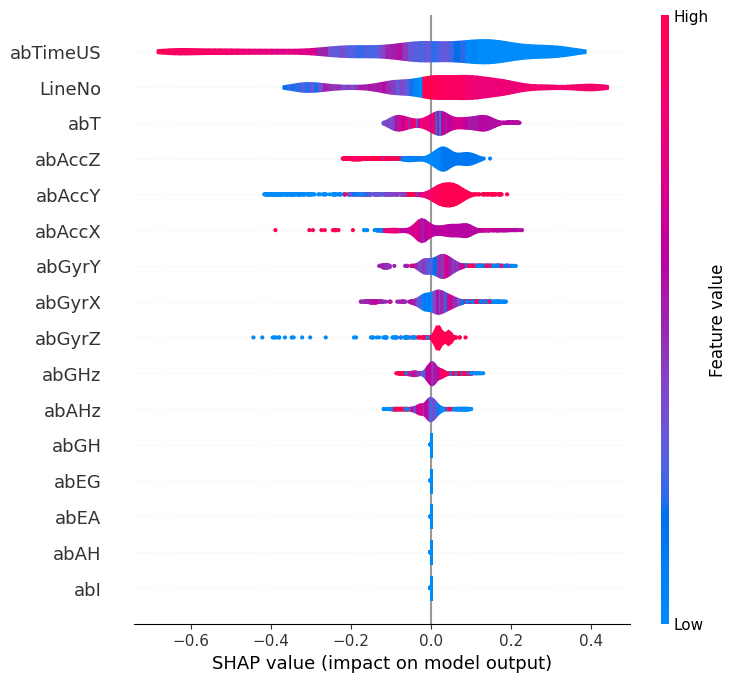

In [57]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 0
# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

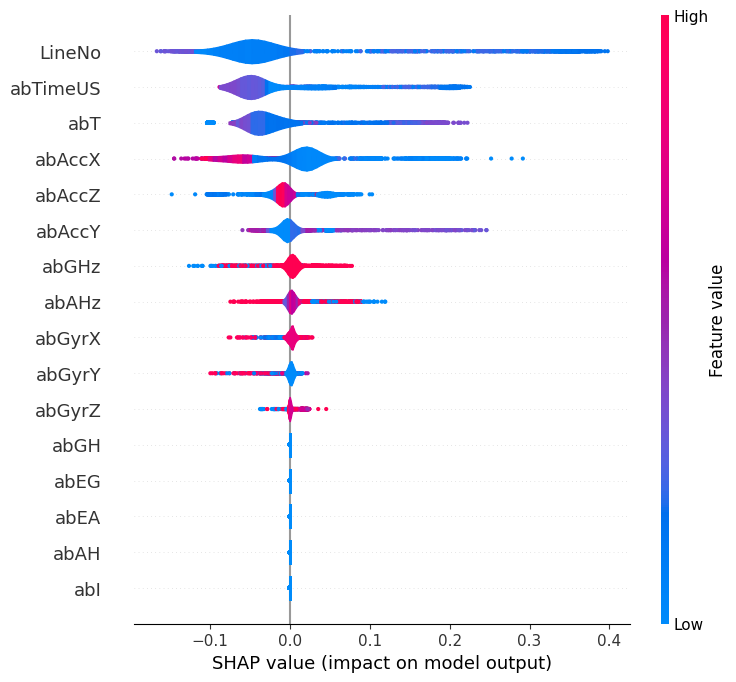

In [58]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 1
# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

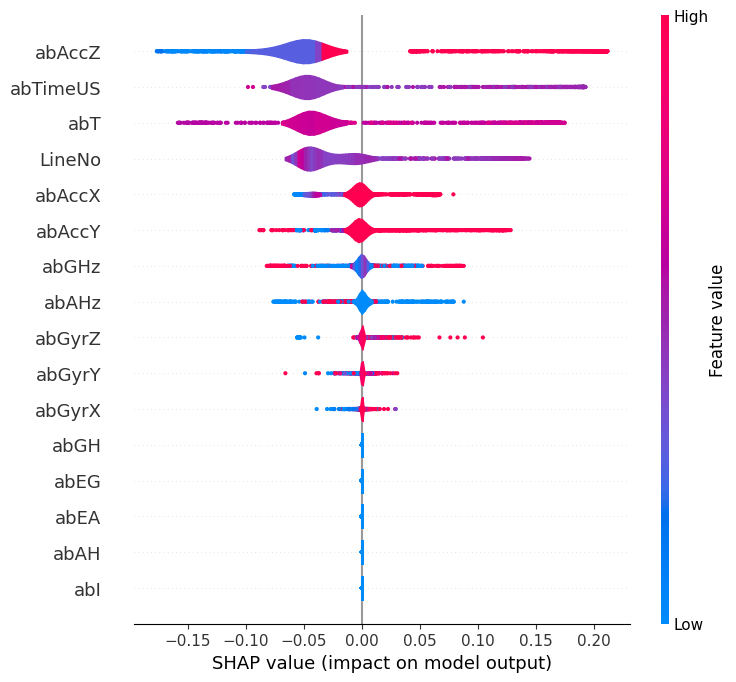

In [59]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 2
# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

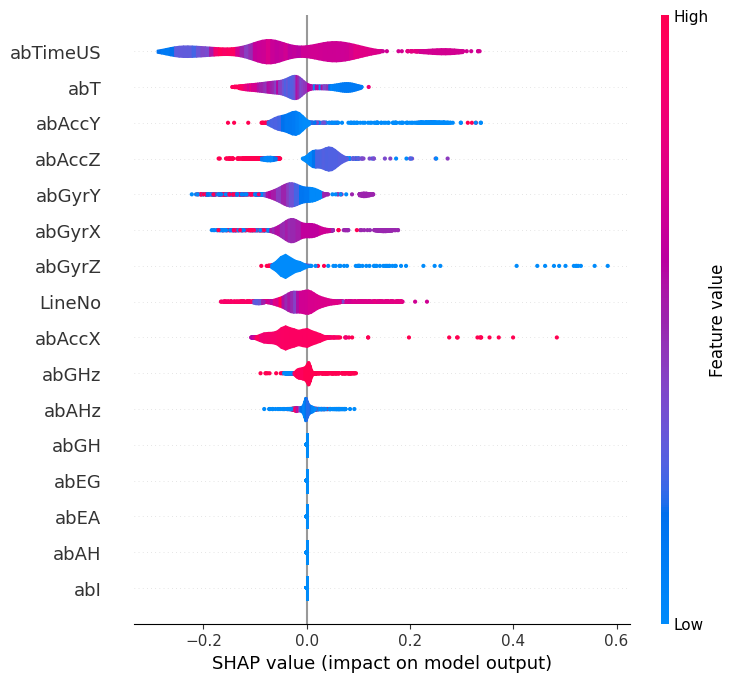

In [60]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 3
# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

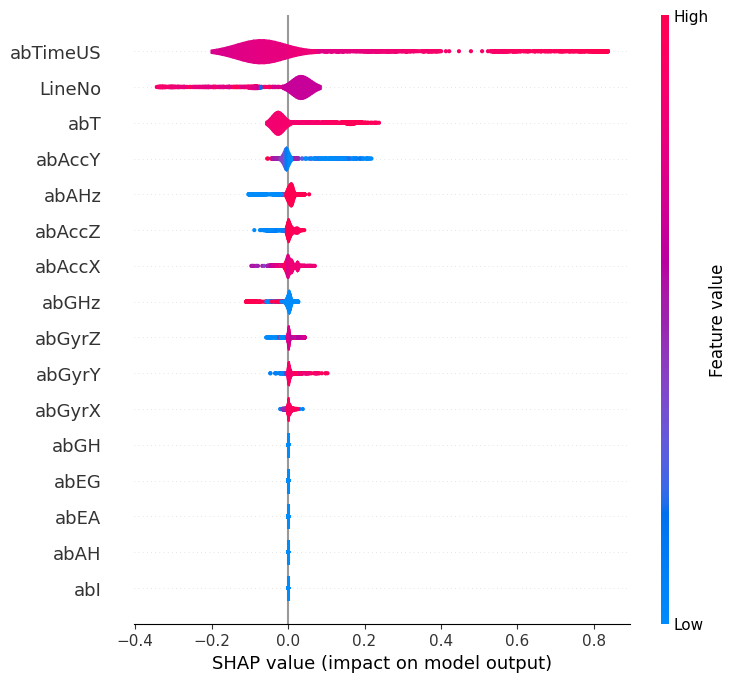

In [61]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 4
# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)

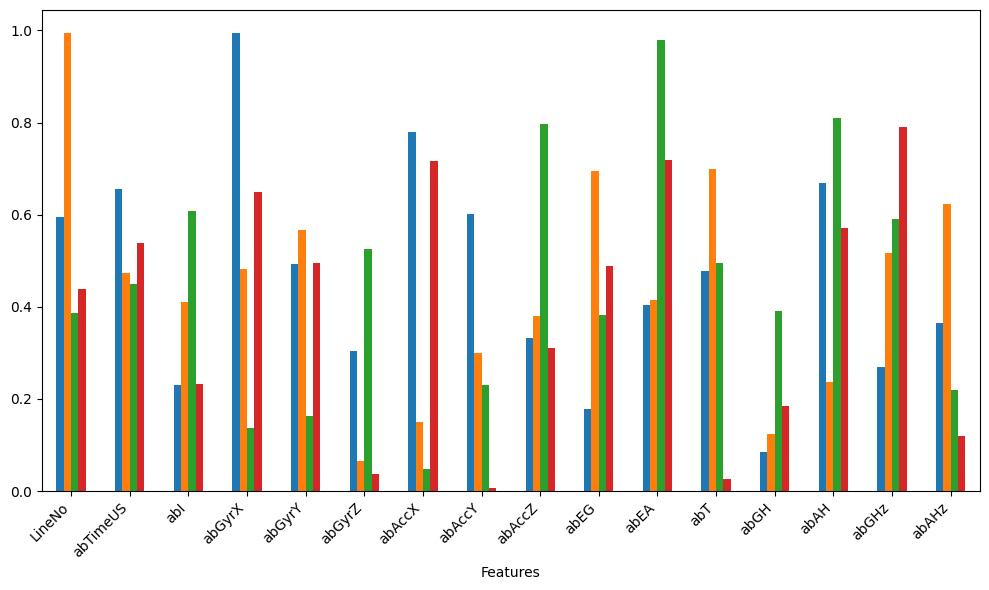

In [89]:
plt.figure(figsize=(10, 6))
shap_df.iloc[:, 1:].plot(kind='bar', ax=plt.gca(),legend=False)
# plt.title("Feature Contribution to UAV Anomalies (Excluding LineNo and abTimeUs)")
plt.xlabel("Features")
# plt.ylabel("Mean |SHAP Value|")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

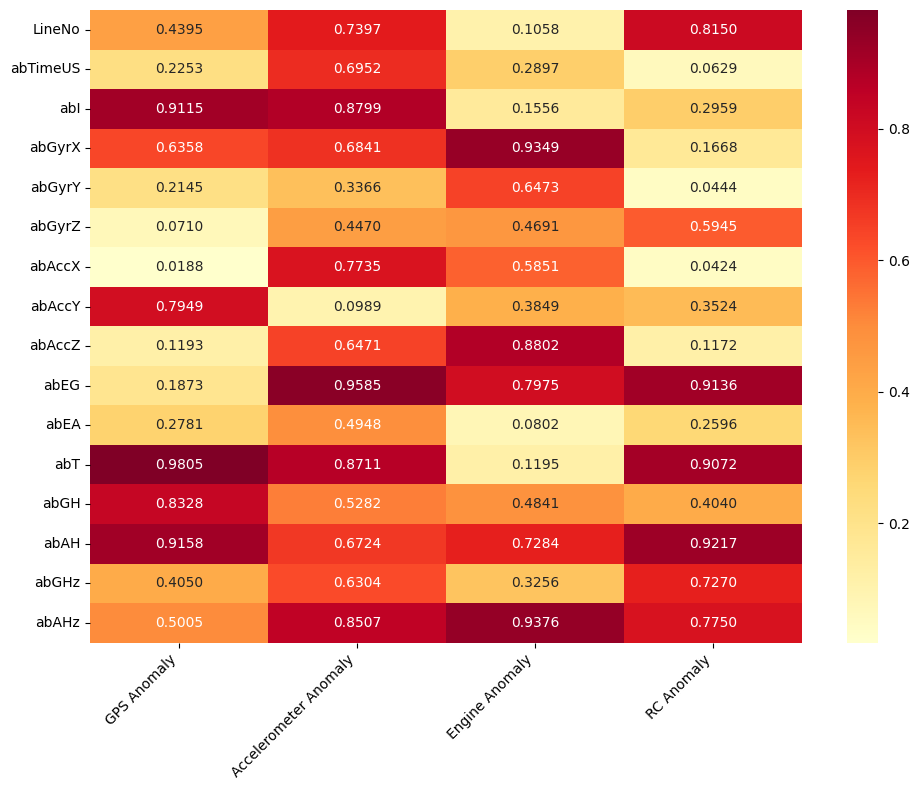

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(shap_df.iloc[:, 1:], annot=True, cmap="YlOrRd", fmt=".4f")
# plt.title("Feature Contribution Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

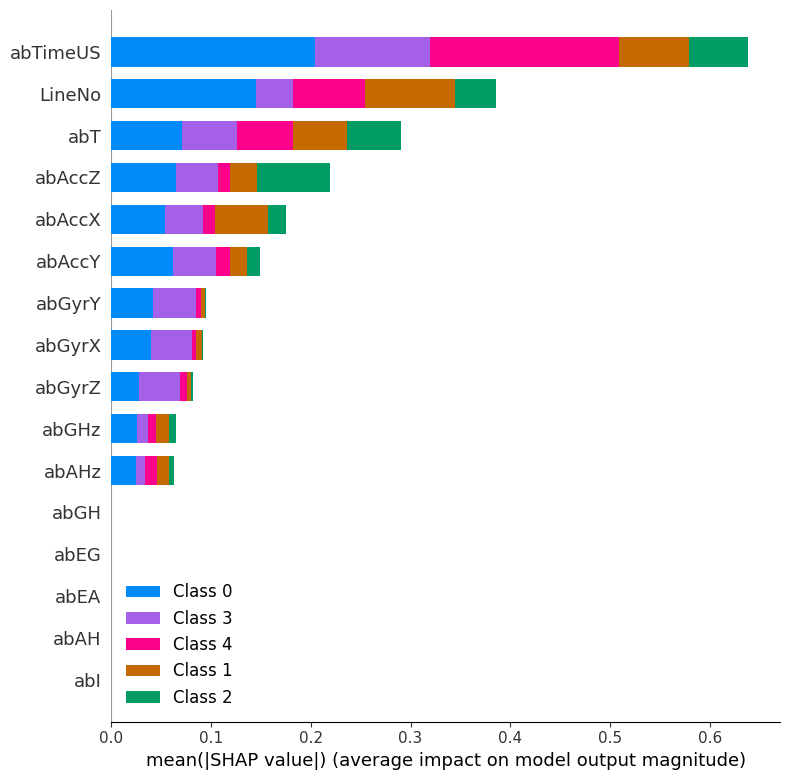

In [64]:
shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)

# **Without TimeUS and LineNO**

In [68]:
shap_df_without = shap_df.drop(index=['abTimeUS', 'LineNo'], errors='ignore')

In [69]:
for anomaly_class in shap_df_without.columns[1:]: # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df_without[anomaly_class].sort_values(ascending=False))


Top Contributing Features for GPS Anomaly:
abT       0.980497
abAH      0.915790
abI       0.911475
abGH      0.832835
abAccY    0.794889
abGyrX    0.635790
abAHz     0.500450
abGHz     0.405045
abEA      0.278090
abGyrY    0.214529
abEG      0.187263
abAccZ    0.119267
abGyrZ    0.071049
abAccX    0.018813
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
abEG      0.958466
abI       0.879873
abT       0.871075
abAHz     0.850701
abAccX    0.773537
abGyrX    0.684133
abAH      0.672432
abAccZ    0.647146
abGHz     0.630388
abGH      0.528222
abEA      0.494805
abGyrZ    0.447015
abGyrY    0.336614
abAccY    0.098901
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
abAHz     0.937624
abGyrX    0.934888
abAccZ    0.880185
abEG      0.797527
abAH      0.728426
abGyrY    0.647342
abAccX    0.585147
abGH      0.484109
abGyrZ    0.469087
abAccY    0.384860
abGHz     0.325583
abI       0.155621
abT       0.11948

In [70]:
top_features = shap_df_without.iloc[:, 1:].idxmax()
print("\nMost Contributing Feature for Each Anomaly Type:\n")
print(top_features)


Most Contributing Feature for Each Anomaly Type:

GPS Anomaly                abT
Accelerometer Anomaly     abEG
Engine Anomaly           abAHz
RC Anomaly                abAH
dtype: object


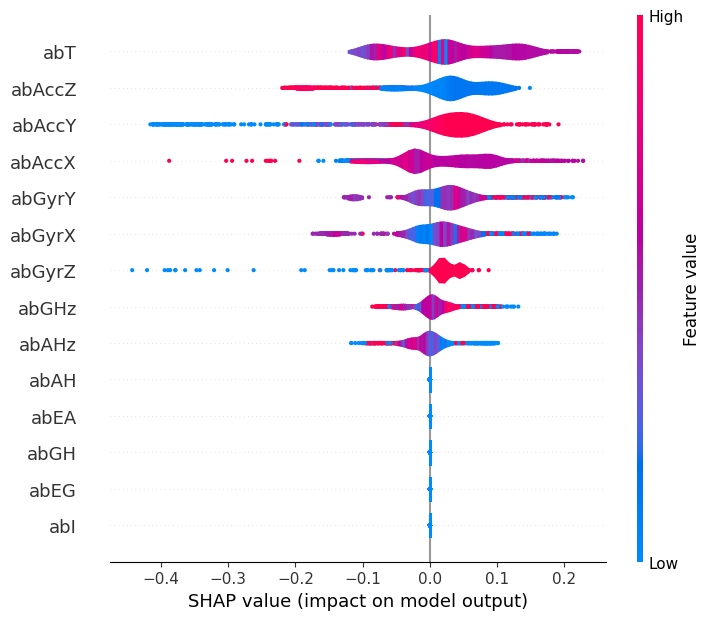

In [72]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 0

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'abTimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


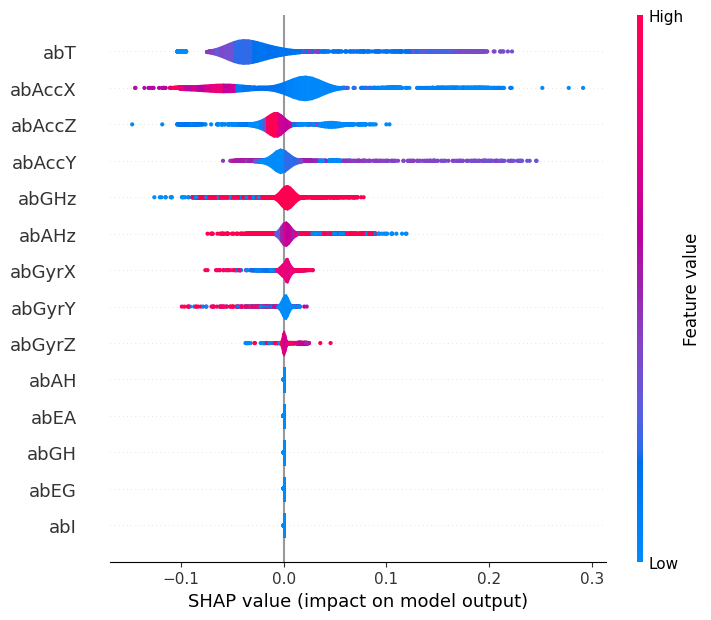

In [73]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 1

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'abTimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


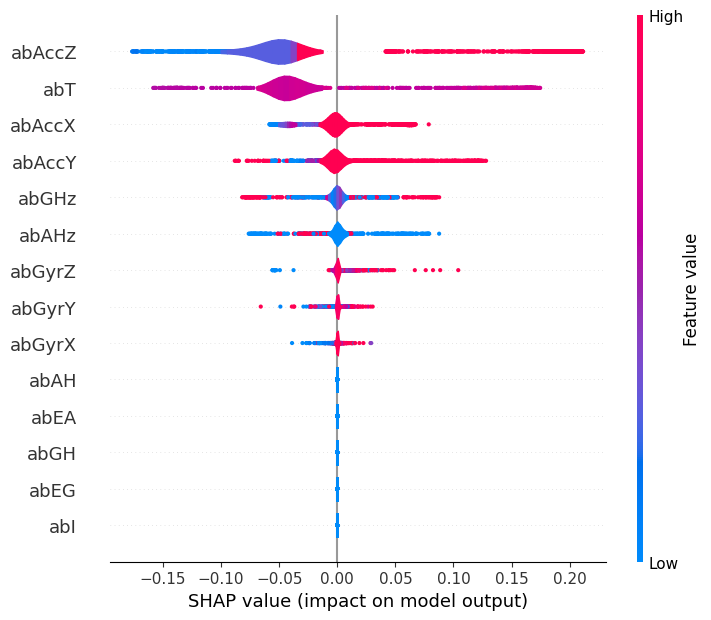

In [74]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 2

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'abTimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


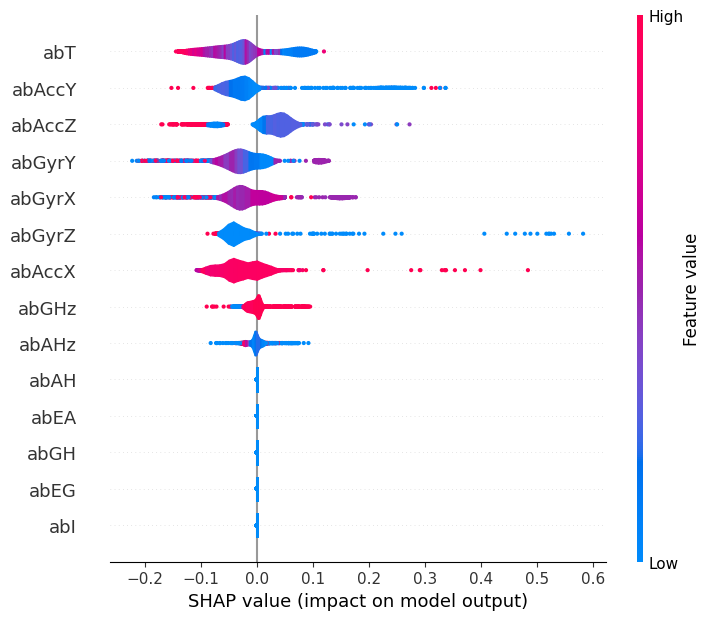

In [75]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 3

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'abTimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


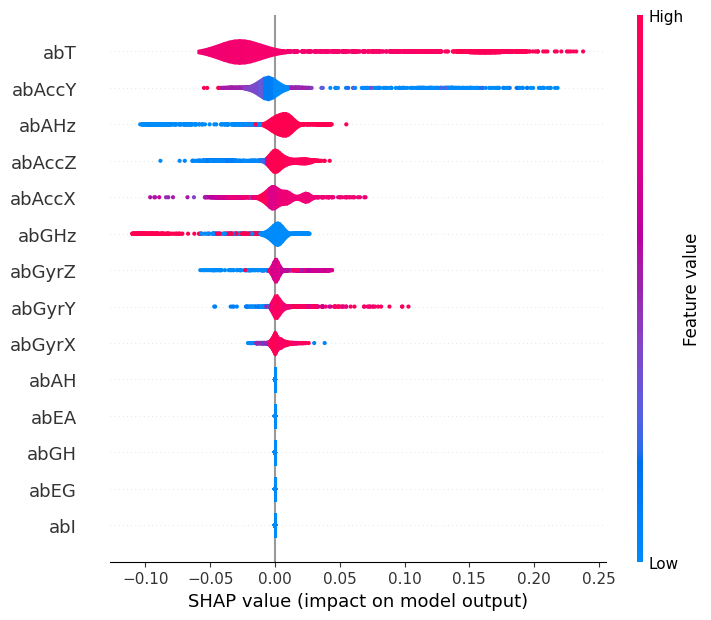

In [76]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 4

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'abTimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


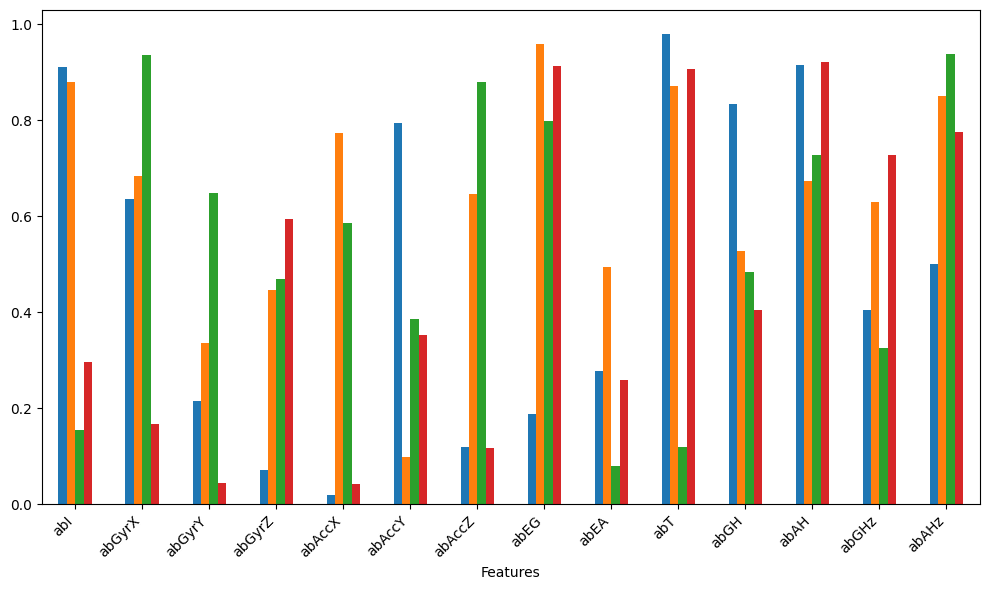

In [79]:
plt.figure(figsize=(10, 6))
shap_df_without.iloc[:, 1:].plot(kind='bar', ax=plt.gca(),legend=False)
# plt.title("Feature Contribution to UAV Anomalies (Excluding LineNo and abTimeUs)")
plt.xlabel("Features")
# plt.ylabel("Mean |SHAP Value|")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

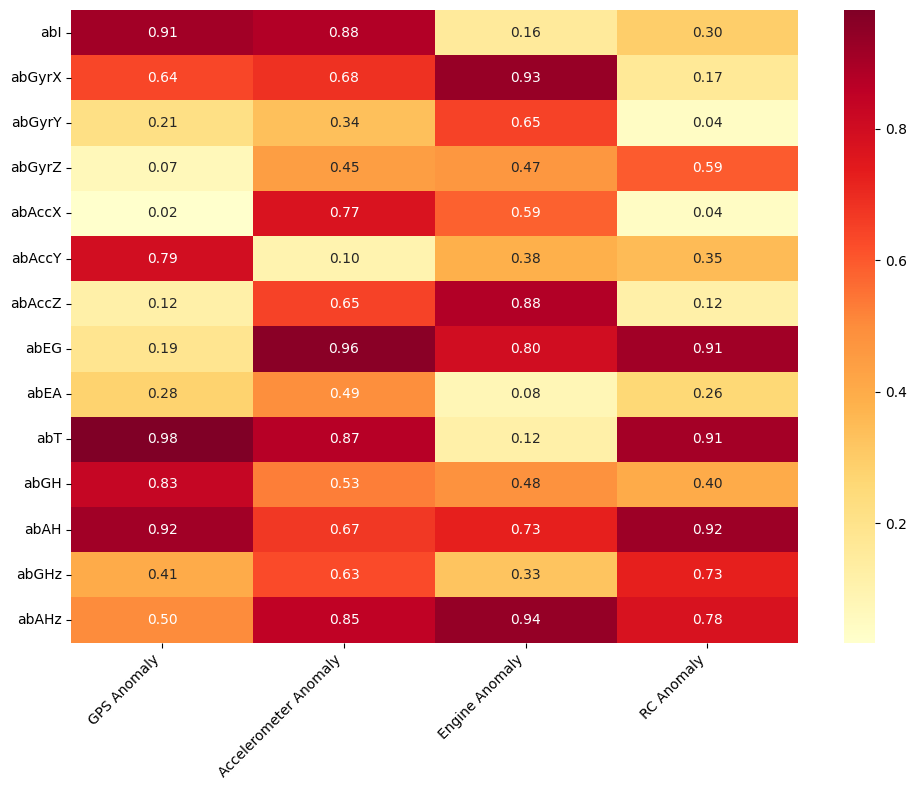

In [78]:
plt.figure(figsize=(10, 8))
sns.heatmap(shap_df_without.iloc[:, 1:], annot=True, cmap="YlOrRd", fmt=".2f")
# plt.title("Feature Contribution Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

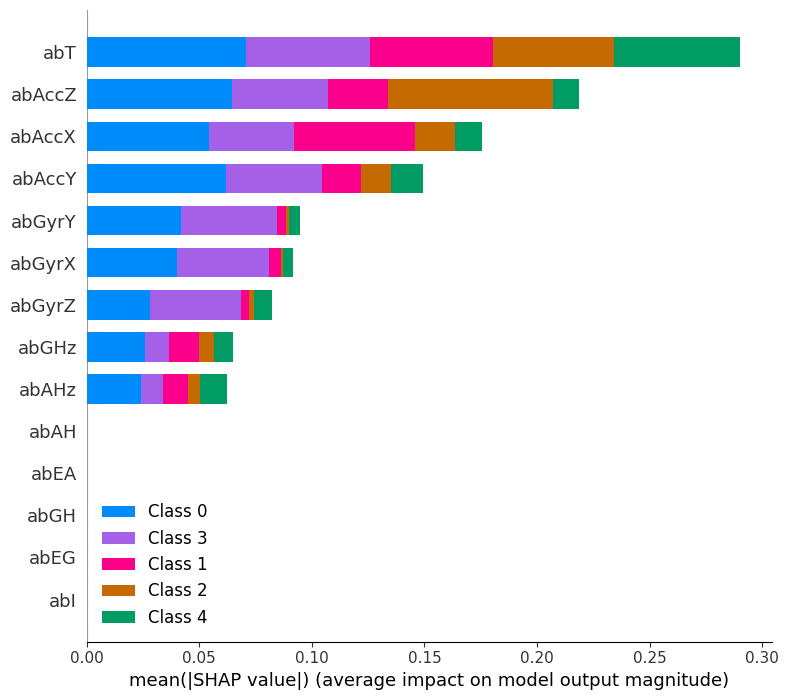

In [81]:
# List of features to exclude
exclude_features = ['LineNo', 'abTimeUS']

# Step 1: Convert X_test_sample to DataFrame (if it's not already)
X_df = pd.DataFrame(X_test_sample, columns=feature_names)

# Step 2: Drop excluded features
X_filtered = X_df.drop(columns=exclude_features, errors='ignore')
filtered_feature_names = X_filtered.columns.tolist()

# Step 3: Drop the corresponding SHAP values
# For multi-class (list of arrays), handle each class separately
if isinstance(shap_values_kernel, list):
    shap_values_filtered = []
    for class_values in shap_values_kernel:
        class_df = pd.DataFrame(class_values, columns=feature_names)
        shap_filtered = class_df.drop(columns=exclude_features, errors='ignore')
        shap_values_filtered.append(shap_filtered.values)
else:
    # shap_values_kernel shape: (n_samples, n_features, n_classes)
    feature_indices = [i for i, f in enumerate(feature_names) if f not in exclude_features]
    shap_values_filtered = shap_values_kernel[:, feature_indices, :]

# Step 4: Plot
shap.summary_plot(shap_values_filtered, X_filtered.values, feature_names=filtered_feature_names)
